In [216]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
from sklearn.pipeline import make_pipeline # type: ignore
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
warnings.simplefilter(action="ignore")

In [217]:
def wrangle(filepath, encode = True):

    # Read the dataset from csv
    df = pd.read_csv(filepath)
    shape_before = df.shape

    # Drop the columns with more that 50% missing values
    columns = df.columns
    for column in columns:
        ratio = df[column].isna().sum()/len(df[column])
        if ratio > 0.5:
            df.drop(columns=column, inplace=True)
            print(f"Dropped '{column}' due to {round(ratio*100, 2)}% missing values.")

    # Drop the columns with zero variance (zero standard deviation)
    numeric_columns = df.select_dtypes(include='number').columns
    for column in numeric_columns:
        if df[column].var() == 0:
            df.drop(columns=column, inplace=True)

    # Drop the outliers from Age
    low, high = df["What is your age?"].quantile([0.01, 0.99])
    mask_age = df["What is your age?"].between(low, high)
    df = df[mask_age]

    # Drop high cardinality categorical variables
    high_cardinality=['Why or why not?', 'Why or why not?.1', 
                      'What US state or territory do you work in?', 
                      'What US state or territory do you live in?']
    df.drop(columns=high_cardinality, inplace=True)

    # Rename a few columns for easier reading
    df.rename(columns={'How many employees does your company or organization have?':'number of employees',
                        'Are you self-employed?' : 'self-employed',
                        'What is your gender?' : 'Gender',
                        'What is your age?' : "Age",
                        'What country do you live in?' : 'Country',
                        'What country do you work in?' : 'Country of work',
                        'Which of the following best describes your work position?':'Job position',
                        'Do you work remotely?':'Remote work',
                        'If so, what condition(s) were you diagnosed with?' : 'Diagnosed condition',
                        'Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?' : 'Insurance covering mental health'
                        }, inplace=True)
    
    # Clean genders
    unique_values = df['Gender'].unique()
    man = ['Male', 'male', 'Male ', 'M', 'm','man', 'Cis male', 'Male.', 'Male (cis)', 
            'cis male', 'Dude', 'mail', 'Male/genderqueer', 'male ','Cis Male', 'cisdude','cis man']
    woman = ['female', 'Female','I identify as female.','Female assigned at birth ', 'F', 'fm', 'f',
            'woman', 'female/woman', 'Cisgender Female', 'Female ','female ', 'Woman','fem', 
            'Female (props for making this a freeform field, though)',
            'Cis-woman','female-bodied; no feelings about gender']
    other = [i for i in unique_values if i not in man and i not in woman]
            
    # Create a dictionary mapping to replace specific values
    gender_map = {**dict.fromkeys(man, 'man'), 
                  **dict.fromkeys(woman, 'woman'), 
                  **dict.fromkeys(other, 'other')}

    # Replace values in the 'Gender' column based on the mapping
    df['Gender'].replace(gender_map, inplace=True)

    # Cluster countries into continents to reduce complexity
    region_mapping = {
                        'Belgium': 'Europe',
                        'Poland': 'Europe',
                        'India': 'Asia', 
                        'United Kingdom': 'Europe', 
                        'United States of America': 'North America', 
                        'Canada': 'North America', 
                        'Germany': 'Europe',
                        'Netherlands': 'Europe', 
                        'Australia':'Australia and Oceania', 
                        'France': 'Europe', 
                        'Brazil': 'South America',
                        'Denmark': 'Europe', 
                        'Sweden': 'Europe', 
                        'Russia': 'Europe',
                        'Spain': 'Europe', 
                        'Norway': 'Europe',
                        'Argentina': 'South America', 
                        'Ireland': 'Europe', 
                        'Italy': 'Europe', 
                        'Colombia': 'South America', 
                        'Czech Republic': 'Europe',
                        'Vietnam': 'Asia', 
                        'Finland': 'Europe', 
                        'Bulgaria': 'Europe', 
                        'South Africa': 'Africa', 
                        'Slovakia': 'Europe',
                        'Bangladesh': 'Asia', 
                        'Pakistan': 'Asia', 
                        'Switzerland': 'Europe', 
                        'New Zealand':'Australia and Oceania',
                        'Afghanistan': 'Asia', 
                        'Romania': 'Europe', 
                        'Other': 'Other', 
                        'Iran': 'Asia', 
                        'Hungary': 'Europe', 
                        'Israel': 'Africa',
                        'Ecuador': 'South America', 
                        'Bosnia and Herzegovina': 'Europe', 
                        'Austria': 'Europe', 
                        'Chile': 'South America', 
                        'Estonia': 'Europe'
                    }

    df['Region'] = df['Country'].map(region_mapping)
    df.drop('Country', axis=1, inplace=True)
    df['Region_of_work'] = df['Country of work'].map(region_mapping)
    df.drop('Country of work', axis=1, inplace=True)
    
    # Separate and one-hot encode values in the 'Job position' column
    ohe_job = df['Job position'].str.get_dummies(sep='|') # Separate the values
    ohe_job = ohe_job.add_prefix('role_') # Add prefix to the column names
    df=pd.concat([df, ohe_job], axis=1)   # Merge into the original dataframe
    df.drop('Job position', axis=1, inplace=True) # Drop the original feature column
        
    # Identify binary features
    binary_features = [col for col in df.columns if df[col].nunique() == 2] 

    # Identify numerical features
    numerical_features = [col for col in df.select_dtypes(include=['number']).columns if col not in binary_features] # Picks numerical features excluding binary features

    # Identify categorical features (excluding binary features)
    categorical_features = [col for col in df.select_dtypes(include=['object', 'category']).columns if col not in binary_features]

    # Identify features not included in any of the feature types above (if any)
    _ = binary_features + numerical_features + categorical_features
    other_features = [col for col in df.columns if col not in _]

    # If other types of features are found, print them out
    if other_features != []:
        print(f"Dropped {other_features} due to irrelevant feature type.") # Because they're not to be included in concat() later

    # Fill in the missing binary and categorical features with mode
    _ = binary_features+categorical_features
    for col in df[_]:
        df[col].fillna(df[col].mode()[0], inplace=True)

    if encode == True:
        # Encode binary features
        encoder = LabelEncoder()
        for col in binary_features:
            df[col] = encoder.fit_transform(df[col])
        
        # Encode categorical features
        for col in categorical_features:
            df[col] = encoder.fit_transform(df[col])

        # Concatenate back to one dataframe 
        df = pd.concat([df[binary_features], df[numerical_features], df[categorical_features]], axis=1)
    else: 
        df.drop(columns="Region_of_work", inplace=True) 
        # Dropped manually, because it is highly correlated with Region, but since the values are not encoded it won't be removed automatically
        
    # Calculate the correlation matrix
    corr_matrix = df.select_dtypes(include=["number"]).corr().abs()

    # Select the upper triangle of the correlation matrix to avoid duplicate correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Initialize an empty set to track columns to drop
    to_drop = set()

    # Iterate over the upper triangle of the correlation matrix
    for column in upper.columns:
        # Skip columns that have already been marked for dropping
        if column in to_drop:
            continue
        for row in upper.index:
            # Check if the correlation value is above the threshold
            threshold = 0.90
            if upper.loc[row, column] > threshold and row not in to_drop:
                to_drop.add(column)  # Add the feature to the drop set
                # Print feature, correlated feature, and the correlation coefficient
                print(f"Dropped '{column}' due to high correlation ({upper.loc[row, column]:.4f}) with '{row}'.")

    # Drop the features from the dataframe
    df = df.drop(columns=to_drop)

    shape_after = df.shape
    print(f"The original dataset's shape went from {shape_before[0]} observations and {shape_before[1]} features to {shape_after[0]} observations and {shape_after[1]} features after wrangling.")
    return df

In [218]:
df = wrangle('mental_health_tech_2016.csv', encode=True)

Dropped 'Is your primary role within your company related to tech/IT?' due to 81.65% missing values.
Dropped 'Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?' due to 79.97% missing values.
Dropped 'Do you know local or online resources to seek help for a mental health disorder?' due to 79.97% missing values.
Dropped 'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?' due to 79.97% missing values.
Dropped 'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?' due to 89.95% missing values.
Dropped 'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?' due to 79.97% missing values.
Dropped 'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?' du

In [219]:
# Check whether or not medical conditions are correlated with a certain IT role 
cols = ["role_Back-end Developer",	"role_Designer", "role_Dev Evangelist/Advocate", "role_DevOps/SysAdmin", "role_Executive Leadership",
        "role_Front-end Developer",	"role_HR", "role_One-person shop",	"role_Other", "role_Sales", "role_Supervisor/Team Lead", 
        "role_Support", "Remote work", "Age", "Have you been diagnosed with a mental health condition by a medical professional?",	
        "Have you ever sought treatment for a mental health issue from a mental health professional?"]
corr = df[cols].corr()
corr.style.background_gradient(axis=None)

,role_Back-end Developer,role_Designer,role_Dev Evangelist/Advocate,role_DevOps/SysAdmin,role_Executive Leadership,role_Front-end Developer,role_HR,role_One-person shop,role_Other,role_Sales,role_Supervisor/Team Lead,role_Support,Remote work,Age,Have you been diagnosed with a mental health condition by a medical professional?,Have you ever sought treatment for a mental health issue from a mental health professional?
role_Back-end Developer,1.000000,-0.082987,0.024492,0.172122,-0.103008,0.179758,-0.079547,-0.024151,-0.218500,0.011011,0.054802,0.035804,0.004683,-0.114635,-0.037716,-0.046636
role_Designer,-0.082987,1.000000,-0.011337,-0.014692,-0.014692,0.216234,0.022829,0.124538,-0.009558,0.150046,0.042698,0.132321,0.001389,-0.031236,0.085324,0.104991
role_Dev Evangelist/Advocate,0.024492,-0.011337,1.000000,0.068531,0.011163,-0.017463,0.005233,0.037078,0.053098,0.054657,0.042556,0.075871,-0.061435,-0.017062,0.014231,0.007513
role_DevOps/SysAdmin,0.172122,-0.014692,0.068531,1.000000,0.006519,0.060966,-0.007424,0.044305,-0.102515,0.058836,0.123173,0.180215,0.017644,-0.002650,-0.033544,-0.032695
role_Executive Leadership,-0.103008,-0.014692,0.011163,0.006519,1.000000,-0.065666,0.093945,0.006244,-0.050391,0.183301,0.126616,0.010390,0.039121,0.096207,-0.008068,-0.005695
role_Front-end Developer,0.179758,0.216234,-0.017463,0.060966,-0.065666,1.000000,-0.051920,0.023784,-0.155521,0.042097,0.021439,0.067707,-0.009962,-0.125556,-0.029318,-0.022694
role_HR,-0.079547,0.022829,0.005233,-0.007424,0.093945,-0.051920,1.000000,0.016180,0.010042,0.144022,0.051684,0.038524,0.014250,0.032930,0.015535,0.062586
role_One-person shop,-0.024151,0.124538,0.037078,0.044305,0.006244,0.023784,0.016180,1.000000,0.003698,0.162039,-0.032624,0.117315,-0.107838,0.148189,0.002512,0.056192
role_Other,-0.218500,-0.009558,0.053098,-0.102515,-0.050391,-0.155521,0.010042,0.003698,1.000000,0.013853,-0.062990,0.010795,-0.005143,0.024354,0.031995,0.030316
role_Sales,0.011011,0.150046,0.054657,0.058836,0.183301,0.042097,0.144022,0.162039,0.013853,1.000000,0.084660,0.186839,0.017692,-0.029214,0.004952,-0.001127


In [220]:
corr = df.corr()
corr["Have you been diagnosed with a mental health condition by a medical professional?"]
corr.style.background_gradient(axis=None)

,self-employed,Is your employer primarily a tech company/organization?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have previous employers?,Have you been diagnosed with a mental health condition by a medical professional?,Have you ever sought treatment for a mental health issue from a mental health professional?,role_Back-end Developer,role_Designer,role_Dev Evangelist/Advocate,role_DevOps/SysAdmin,role_Executive Leadership,role_Front-end Developer,role_HR,role_One-person shop,role_Other,role_Sales,role_Supervisor/Team Lead,role_Support,Age,number of employees,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Would you bring up a mental health issue with a potential employer in an interview?,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?,How willing would you be to share with friends and family that you have a mental illness?,Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?,Do you have a family history of mental illness?,Have you had a mental health disorder in the past?,Do you currently have a mental health disorder?,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",Gender,Remote w

In [221]:
# Set your threshold (e.g., 0.3)
threshold = 0.3

# Get the correlation values with the target column
corr_with_target = corr["Have you been diagnosed with a mental health condition by a medical professional?"]

# Filter the features that have an absolute correlation coefficient greater than the threshold
selected_features = corr_with_target[abs(corr_with_target) > threshold].index

# Display the selected features
selected_features_list = selected_features.tolist()
print("Selected features:", selected_features_list)

Selected features: ['Have you been diagnosed with a mental health condition by a medical professional?', 'Have you ever sought treatment for a mental health issue from a mental health professional?', 'Have you had a mental health disorder in the past?', 'Do you currently have a mental health disorder?', 'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?', 'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?']


In [222]:
# Set your threshold (e.g., 0.3)
threshold = 0.3

# Get the correlation values with the target column
corr_with_target = corr["Have you ever sought treatment for a mental health issue from a mental health professional?"]

# Filter the features that have an absolute correlation coefficient greater than the threshold
selected_features = corr_with_target[abs(corr_with_target) > threshold].index

# Display the selected features
selected_features_list = selected_features.tolist()
print("Selected features:", selected_features_list)

subset = df[selected_features_list]


Selected features: ['Have you been diagnosed with a mental health condition by a medical professional?', 'Have you ever sought treatment for a mental health issue from a mental health professional?', 'Have you had a mental health disorder in the past?', 'Do you currently have a mental health disorder?', 'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?', 'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?']


In [223]:
def pca_explained_variance(df, threshold):
    df = df
    # Apply PCA
    scaled_df = MinMaxScaler().fit_transform(df)
    pca = PCA().fit(scaled_df)

    # Calculate explained variance ratio
    explained_variance = pca.explained_variance_ratio_

    # Plot cumulative explained variance
    plt.plot(np.cumsum(explained_variance))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    # Set x-tick labels to start from 1 instead of 0
    num_components = len(explained_variance)
    plt.xticks(np.arange(num_components), np.arange(1, num_components + 1))
    plt.show()

    # Find the number of components that explain the wanted percentage of the variance
    threshold = threshold
    cumulative_variance = np.cumsum(explained_variance)
    num_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f'Number of components that explain {threshold*100}% variance: {num_components}\n')

    # Extract the top components
    top_n = num_components
    top_components = pca.components_[:top_n]

    # Calculate the absolute contributions of each feature
    feature_contributions = np.abs(top_components).sum(axis=0)

    # Create a DataFrame to view feature contributions
    features_df = pd.DataFrame({
        'Feature': df.columns,
        'Contribution': feature_contributions
    })

    # Sort by contribution
    features_df = features_df.sort_values(by='Contribution', ascending=False)
    sub_df = df[features_df['Feature'].head(top_n)]
    print(features_df.head(top_n))  # Print the top_n features with the highest contributions
    return sub_df

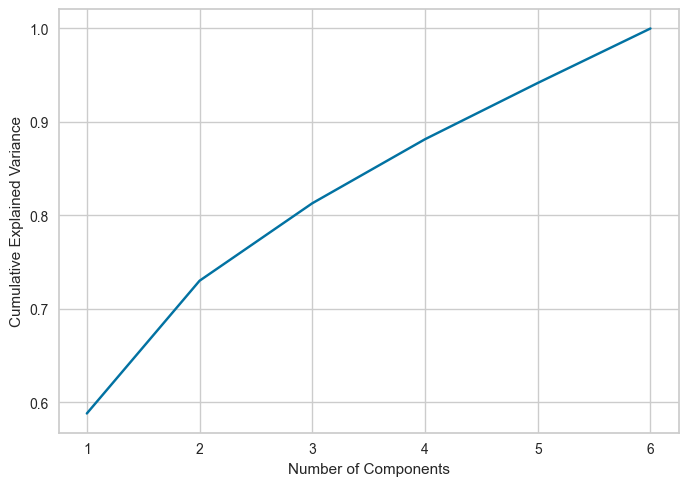

Number of components that explain 80.0% variance: 3

                                             Feature  Contribution
1  Have you ever sought treatment for a mental he...      1.435902
4  If you have a mental health issue, do you feel...      1.357839
3    Do you currently have a mental health disorder?      1.177492


In [224]:
sub_df = pca_explained_variance(subset, 0.80)

In [225]:
sub_df.columns

Index(['Have you ever sought treatment for a mental health issue from a mental health professional?',
       'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?',
       'Do you currently have a mental health disorder?'],
      dtype='object')

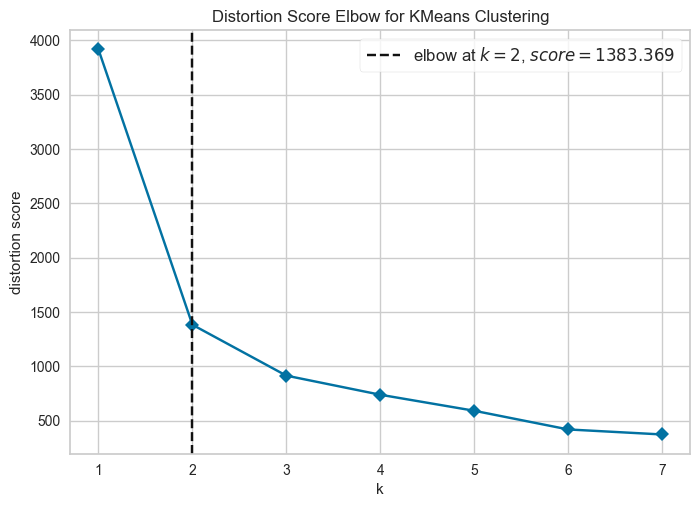

In [226]:
# create a k-Means model an Elbow-Visualizer
visualizer = KElbowVisualizer(KMeans(), k=(1,8), timings=False)

# fit the visualizer and show the plot
visualizer.fit(sub_df)        
visualizer.show();     

In [227]:
model = make_pipeline(
                        MinMaxScaler(),
                        KMeans(n_clusters=2, n_init='auto', random_state=42)
                     )
# Fit the model and transform the data
transformed_data = model.fit_transform(sub_df)

# Calculate the silhouette score on the transformed data
labels = model.named_steps['kmeans'].labels_
sil_KM = silhouette_score(transformed_data, labels)
sil_KM

0.7636051855416253

In [228]:
df["Cluster"] = labels
df_0 = df[df["Cluster"]==0]
df_1 = df[df["Cluster"]==1]

In [229]:
assert df.shape[0] == df_0.shape[0] + df_1.shape[0]

In [230]:
pca_cols = ['Have you ever sought treatment for a mental health issue from a mental health professional?',
            'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?',
            'Do you currently have a mental health disorder?']

In [231]:
df.groupby("Cluster")[pca_cols].agg(['mean', 'std', 'min', 'max'])

Have you ever sought treatment for a mental health issue from a mental health professional?  \
                                                                                               mean   
Cluster                                                                                               
0                                                      1.0                                            
1                                                      0.0                                            

                      \
         std min max   
Cluster                
0        0.0   1   1   
1        0.0   0   0   

        If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?  \
                                                                                                                    mean   
Cluster                                                                                                                    
0                                                 2.749086                                                                 
1                                                 1.405822                                                                 

                          Do you currently have a mental health disorder?  \
              std min max                                            mean   
Cluster                                                                     
0        1.354447   0   4                                        1.399513   
1        1.023581   0   4                                        0.852740   

                           
              std min max  
Cluster                    
0        0.821183   0   2  
1        0.569878   0   2

In [232]:
ori_df_clustered = wrangle('mental_health_tech_2016.csv', encode=False)
ori_df_clustered["Cluster"] = labels

Dropped 'Is your primary role within your company related to tech/IT?' due to 81.65% missing values.
Dropped 'Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?' due to 79.97% missing values.
Dropped 'Do you know local or online resources to seek help for a mental health disorder?' due to 79.97% missing values.
Dropped 'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?' due to 79.97% missing values.
Dropped 'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?' due to 89.95% missing values.
Dropped 'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?' due to 79.97% missing values.
Dropped 'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?' du

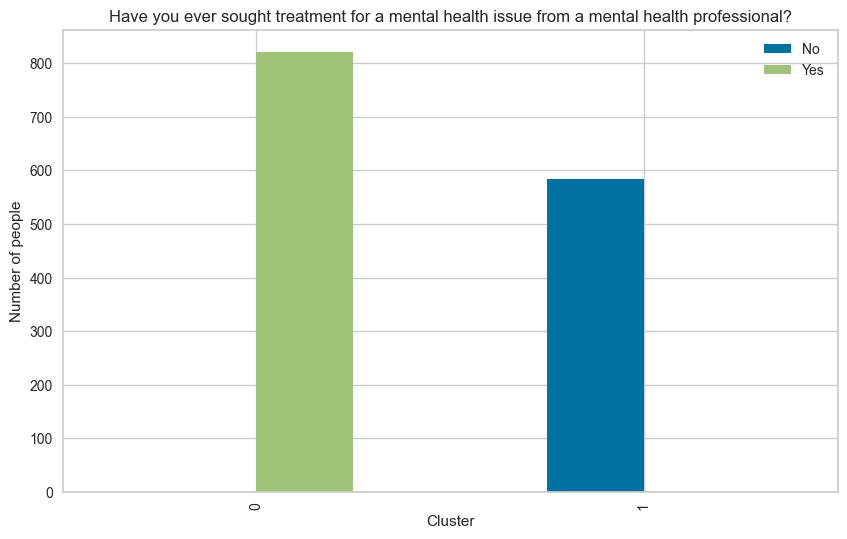

Cluster  Have you ever sought treatment for a mental health issue from a mental health professional?
0        1                                                                                              821
1        0                                                                                              584
Name: count, dtype: int64

In [233]:
value_counts_sought_treatment = ori_df_clustered.groupby("Cluster")[pca_cols[0]].value_counts().unstack()

value_counts_sought_treatment.plot(kind='bar', figsize=(10,6))
plt.xlabel("Cluster")
plt.ylabel("Number of people")
plt.title(pca_cols[0])
plt.legend(["No","Yes"],loc='best')
plt.show()
ori_df_clustered.groupby("Cluster")[pca_cols[0]].value_counts()

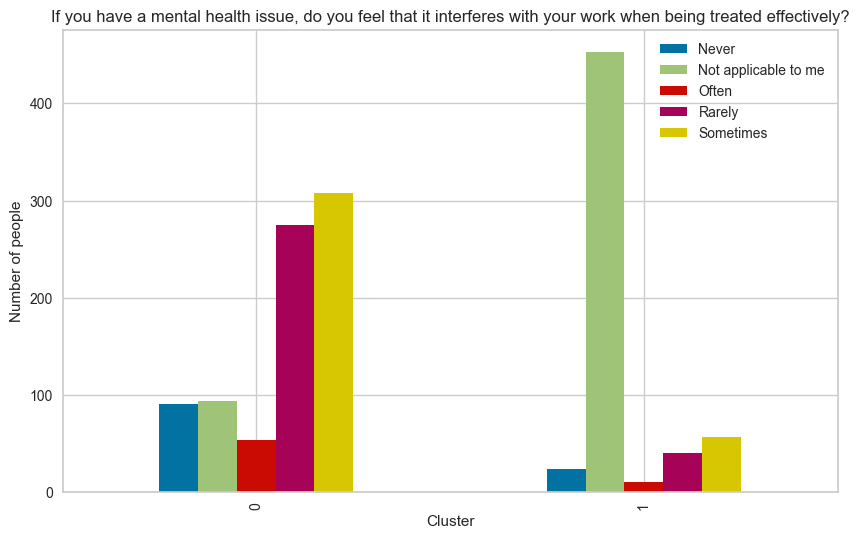

Cluster  If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?
0        Sometimes                                                                                                           308
         Rarely                                                                                                              275
         Not applicable to me                                                                                                 94
         Never                                                                                                                91
         Often                                                                                                                53
1        Not applicable to me                                                                                                453
         Sometimes                                                                                      

In [234]:
value_counts_inference_w_work = ori_df_clustered.groupby("Cluster")[pca_cols[1]].value_counts().unstack()

value_counts_inference_w_work.plot(kind='bar', figsize=(10,6))
plt.xlabel("Cluster")
plt.ylabel("Number of people")
plt.title(pca_cols[1])
plt.legend(loc='best')
plt.show()
ori_df_clustered.groupby("Cluster")[pca_cols[1]].value_counts()

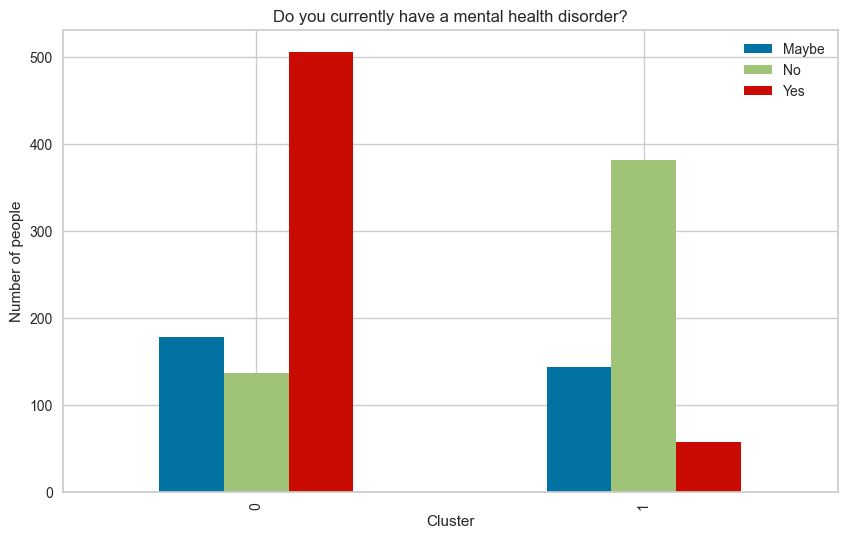

Cluster  Do you currently have a mental health disorder?
0        Yes                                                506
         Maybe                                              178
         No                                                 137
1        No                                                 382
         Maybe                                              144
         Yes                                                 58
Name: count, dtype: int64

In [235]:
value_counts_have_disorder = ori_df_clustered.groupby("Cluster")[pca_cols[2]].value_counts().unstack()

value_counts_have_disorder.plot(kind='bar', figsize=(10,6))
plt.xlabel("Cluster")
plt.ylabel("Number of people")
plt.title(pca_cols[2])
plt.legend(loc='best')
plt.show()
ori_df_clustered.groupby("Cluster")[pca_cols[2]].value_counts()